## Clasificación Supervisada

#### Descripción del dataset

El dataset es una versión manipulada de Adult Census Income en kaggle: https://www.kaggle.com/datasets/uciml/adult-census-income

Las columnas se describen a continuación:
- index: índice del dataframe
- age: edad de la persona
- workclass: clase o tipo de trabajador 
- education: variable cualitativa del nivel de educación máxima obtenida
- education.num: variable cuanlitativa ordinal, ya que representa el nivel de eduación máxima obtenida con un número, en orden ascendete desde menor a mayor nivel de eduación
- marital.status: estado civil y/o relaciones familiares
- occupation: área de trabajo u ocupación
- relationship: relación con la pareja
- race: raza
- sex: sexo
- capital.gain: ganancias de capital neto anual
- capital.loss: pérdidas de capital neto anual
- hours.per.week: horas trabajadas por semana en promedio
- native.country: país de origen
- income: variable que determina si el ingreso de la persona es mayor o menor a USD \$50000 anuales 
- ID: identificador de la base de datos

#### Objetivo

Utilizar algoritmos de aprendizaje supervisado para predecir si el income de un CSV no etiquetado será mayor o menor a \$50000 anuales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import os

from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

- Se muestra una previsualización del las primeras filas del dataset
- Se realiza una descripción estadística de las columnas numéricas del dataset
- Se agrega otra columna para corroborar que el número de nivel de educación está efectivamente correlacionado con la descripción del nivel de educación

In [2]:
# Read CSV (se hizo en Jupyter Notebook de manera local)
df_train_csv = pd.read_csv('./datasets/train.csv',index_col=0)
df_train = pd.read_csv('./datasets/train.csv',index_col=0)

df_target_csv = pd.read_csv('./datasets/test.csv',index_col=0)
df_target = pd.read_csv('./datasets/test.csv',index_col=0)

df_example = pd.read_csv('./datasets/submit_example.csv')

print(f'df_train_shape: {df_train.shape}')
print(f'df_target_shape: {df_target.shape}')
print(f'df_submit_example: {df_example.shape}')

try:
    os.mkdir('./datasets/figures/')
except:
    pass

df_train_shape: (27656, 15)
df_target_shape: (4881, 14)
df_submit_example: (4881, 2)


In [3]:
df_train.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ID
index,,,,,,,,,,,,,,,
24466,30,Local-gov,HS-grad,9,Divorced,Protective-serv,Own-child,White,Female,0,0,32,United-States,<=50K,24451
985,37,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,1848,40,United-States,>50K,985
30250,41,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,>50K,30229
7107,45,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K,7107
27656,28,Private,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K,27639


In [4]:
df_train.describe()

,age,education.num,capital.gain,capital.loss,hours.per.week,ID
count,27656.000000,27656.000000,27656.000000,27656.000000,27656.000000,27656.000000
mean,38.610356,10.093506,1099.991503,88.284387,40.446666,16267.565736
std,13.659928,2.566083,7487.323462,405.821328,12.369212,9403.092602
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,8104.750000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,16291.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,24416.250000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,32535.000000


In [5]:
# Check education number y level of education
df_train['education_numbered'] = df_train['education.num'].apply(str).str.zfill(2).str.cat(df_train['education'], sep='_')
df_target['education_numbered'] = df_target['education.num'].apply(str).str.zfill(2).str.cat(df_target['education'], sep='_')
sorted(df_train['education_numbered'].unique())

['01_Preschool',
 '02_1st-4th',
 '03_5th-6th',
 '04_7th-8th',
 '05_9th',
 '06_10th',
 '07_11th',
 '08_12th',
 '09_HS-grad',
 '10_Some-college',
 '11_Assoc-voc',
 '12_Assoc-acdm',
 '13_Bachelors',
 '14_Masters',
 '15_Prof-school',
 '16_Doctorate']

#### Analisis de nulos

- Se puede ver que no hay columnas con registros nulos.
- Para las columnas no numéricas se muestra un resumen de los porcentajes de registros para cada valor único de esa columna
    - Se encuentra que hay registros marcados como "?" que no se muestran como nulos. Debido a la baja cantidad porcentual (menor al 6\% en el peor caso -columna native.country-). También se encuentra este tipo de registros en las columnas occupation y workclass
    - Se asume que estos registros marcados como "?" son desconocidos o nulos y se los remueve, conservando un 92.67% de los datos, por lo que se asume que el análisis no se verá afectado

In [6]:
df_train.isna().mean()

age                   0.0
workclass             0.0
education             0.0
education.num         0.0
marital.status        0.0
occupation            0.0
relationship          0.0
race                  0.0
sex                   0.0
capital.gain          0.0
capital.loss          0.0
hours.per.week        0.0
native.country        0.0
income                0.0
ID                    0.0
education_numbered    0.0
dtype: float64

In [7]:

for col in df_train.columns:
    if(not(is_numeric_dtype(df_train[col]))):
        print(col)
        print(round((df_train[col].value_counts(normalize=True))*100,2))
        print('_'*10)
    else:
        continue

workclass
Private             69.71
Self-emp-not-inc     7.80
Local-gov            6.40
?                    5.56
State-gov            4.04
Self-emp-inc         3.45
Federal-gov          2.97
Without-pay          0.05
Never-worked         0.03
Name: workclass, dtype: float64
__________
education
HS-grad         32.30
Some-college    22.50
Bachelors       16.57
Masters          5.33
Assoc-voc        4.15
11th             3.55
Assoc-acdm       3.20
10th             2.87
7th-8th          1.93
Prof-school      1.79
9th              1.55
12th             1.32
Doctorate        1.27
5th-6th          0.99
1st-4th          0.50
Preschool        0.16
Name: education, dtype: float64
__________
marital.status
Married-civ-spouse       45.99
Never-married            32.78
Divorced                 13.63
Widowed                   3.10
Separated                 3.10
Married-spouse-absent     1.32
Married-AF-spouse         0.08
Name: marital.status, dtype: float64
__________
occupation
Prof-specialty   

In [8]:
# Quitar valores nulos (denotados con "?") en Train
df_train = df_train[df_train['workclass'] != "?"]
df_train = df_train[df_train['occupation'] != "?"]
df_train = df_train[df_train['native.country'] != "?"]

In [9]:
# Quitar valores nulos (denotados con "?") en target
df_target = df_target[df_target['workclass'] != "?"]
df_target = df_target[df_target['occupation'] != "?"]
df_target = df_target[df_target['native.country'] != "?"]

In [10]:
print(
f'Cantidad de datos luego de eliminar "?" de las columnas workclass, occupation y native.country: \n\
Train: {df_train.shape[0]/df_train_csv.shape[0]*100:.2f} % \n\
Test: {df_target.shape[0]/df_target_csv.shape[0]*100:.2f} %'
)

Cantidad de datos luego de eliminar "?" de las columnas workclass, occupation y native.country: 
Train: 92.67 % 
Test: 92.40 %


#### Remover Outliers

Para quitar outliers se utiliza el criterio del rango medio intercuartil (IQC), donde se calcula que los outliers son aquellas observaciones menores a $1.5*Q_1$ y mayores a $1.5*Q_3$, donde $Q_1$ es el valor de la variable por debajo del que se encuentran el 25\% de las observaciones y $Q_3$ es el valor de la variable por debajo del que se encuentras el 75\% de las observaciones (también son llamados $Q_{25\%}$ y $Q_{75\%}$. 
Se realizaron los histogramas y boxplots de las variables cualitativas y se obtiveron las siguientes conclusiones.
- Para la variable _Age_, los outliers representan menos del 1\% de los datos, estos registros pueden ser eliminados para mejorar los parámetros de presición del modelo resultante con el set de datos de entrenamiento.
- Para la variable _hours.per.week_, la cantidad de outliers que se obtiene con el boxplot (más del 25\% de los datos) es indicativo de que la variable tiene una gran concentración en la mediana, lo que se evidencia con el histograma, donde se ve que la cantidad de gente que trabaja una media de 40 horas semanales es de un orden de magnitud mayor que el resto. Para los propóitos del modelo se decide no quitar estos outliers, ya que representan una cantidad importante de los datos y la distribución no sigue una tendencia de una distribución normal.
- Con respecto a las variables _capital.gain_ y _capital.loss_, tienen un comportamiento similar a la variable _hours.per_week_, donde la mediana es el valor 0, y tiene al menos un orden de magnitud mayor que los demás valores que adopta la variable (denotado en el histograma con escala logaritmica)

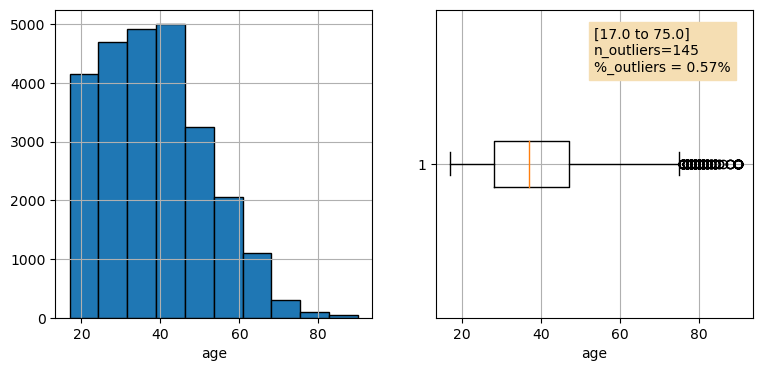

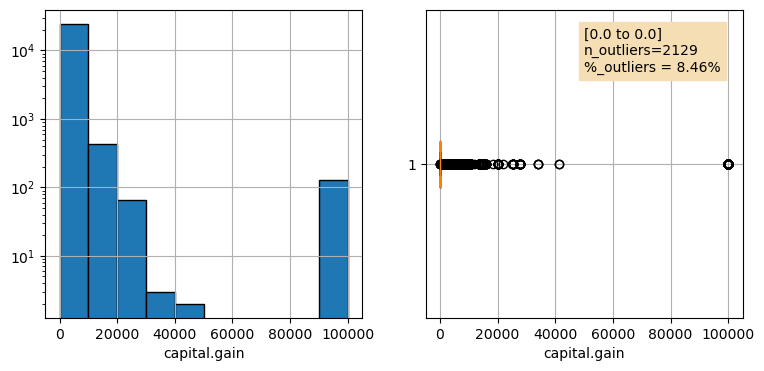

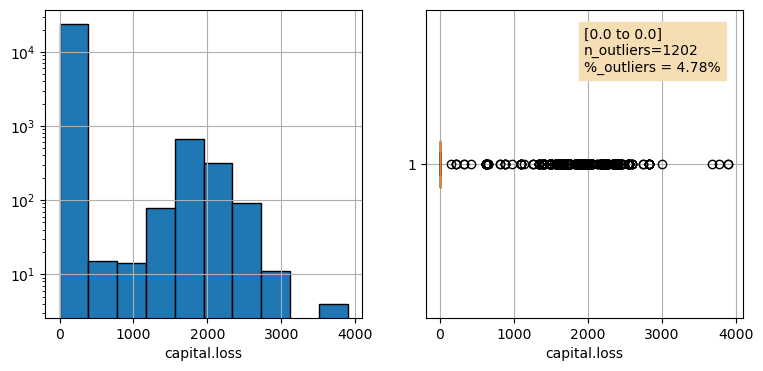

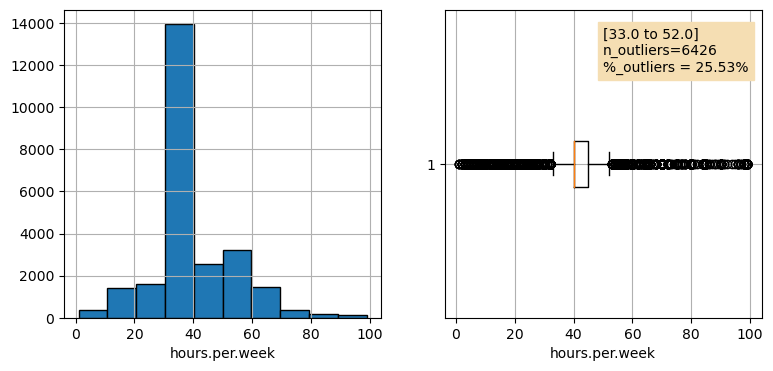

In [11]:
cols_to_remove_outliers = ['age']

for col in df_train.columns:
    if((is_numeric_dtype(df_train[col])) and (col != 'ID') and (col != 'education.num')):
        fig, axes = plt.subplots(1,2,figsize=(9,4))
        ax = axes[0]
        ax.set_xlabel(col)
        ax.hist(df_train[col],edgecolor='black')
        ax.set_xlabel(col)
        if('capital' in col):
            ax.set_yscale('log')
        ax.grid(True)
        
        ax = axes[1]
        box = ax.boxplot(df_train[col],vert=False)
        lw = box['whiskers'][0].get_xdata()[1] # High whisker
        hw = box['whiskers'][1].get_xdata()[1] # Low whisker
        n_out = len(df_train[(df_train[col] < lw) | (df_train[col] > hw) ])
        ax.annotate(text= '\n'.join((
                           f'[{lw} to {hw}]',
                           f'n_outliers={n_out}',
                           f'%_outliers = {(n_out/len(df_train[col]))*100:.2f}%'
                           )),
                    xy=(0.5,0.8),
                    xycoords='axes fraction',
                    backgroundcolor='wheat')
        ax.set_xlabel(col)
        ax.grid(True)
        
        # Remove outliers based on conclutions
        if(col in cols_to_remove_outliers):
            df_train = df_train[(df_train[col] > lw) & (df_train[col] < hw)]

In [12]:
print(
f'Cantidad de datos luego de eliminar "?" de las columnas workclass, occupation y native.country y de quitar outliers: \n\
Train: {df_train.shape[0]/df_train_csv.shape[0]*100:.2f} %'
)

Cantidad de datos luego de eliminar "?" de las columnas workclass, occupation y native.country y de quitar outliers: 
Train: 91.01 %


### EDA

A partir de algunos análisis gráficos y de preparación del dataset para su procesamiento con algoritmos de ML se obtienen conclusiones en cada sección

#### Matriz de Corrleación de Pearson
- No se observa una correlación marcada entre las variables numéricas
- No se espera poder realizar un análisis de regresión con este comportamiento

C:\Users\fdadam\AppData\Local\Temp\ipykernel_14176\4161823864.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))
C:\Users\fdadam\AppData\Local\Temp\ipykernel_14176\4161823864.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), mask=mask, cmap=cmap, center=0,


<Axes: >

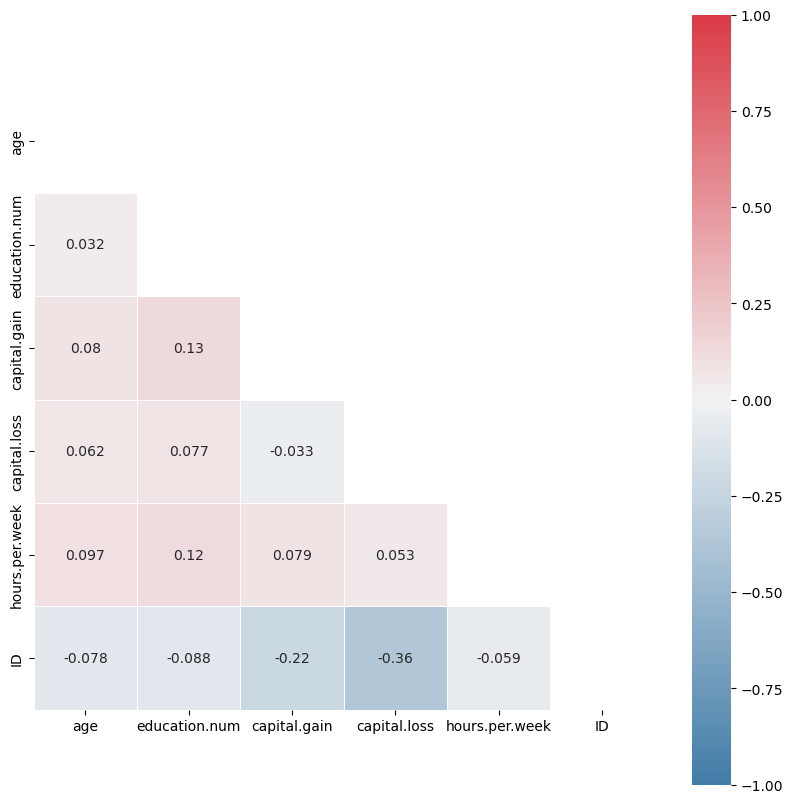

In [13]:
mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(df_train.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True,vmin=-1,vmax=1)

#### _Income_ porcentual
- Solo un 25.38\% del los encuestados tiene un ingreso superior a los USD $50.000 anuales

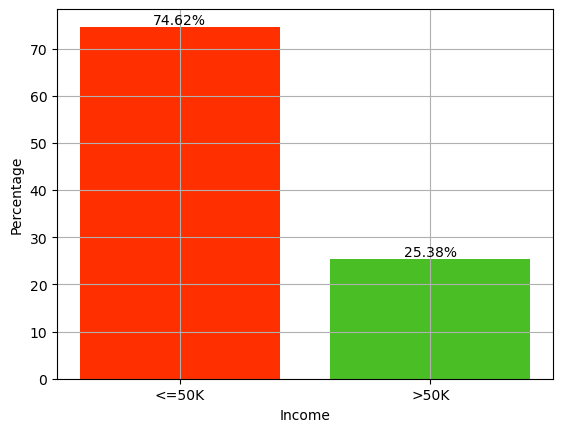

In [14]:
myRed = '#ff2f00'
myGreen = '#49be25'
df_grouped = df_train.groupby(['income']).count()['ID']*100/len(df_train)

fig, ax = plt.subplots(1,1)
bar = ax.bar(df_grouped.index,df_grouped.values,color=[myRed,myGreen])
ax.bar_label(bar,fmt='{:.2f}%')
ax.set_xlabel('Income')
ax.set_ylabel('Percentage')
ax.grid()

plt.savefig('./datasets/figures/income.png',dpi=600)

#### Edad (_age_)
- Se utilizó un kbins discretizer para separarlos en 5 bins uniformes, ya que era una variable continua con mucha dispersión
- A medida que la edad es menor, mayor es la discrepancia porcentual entre la gente que puede llegar al target anual de ingresos o no
- En todos los grupos etarios hay gente que supera el target de ingresos.
- La mayoría de los encuestados son jóvenes (18 a 29)

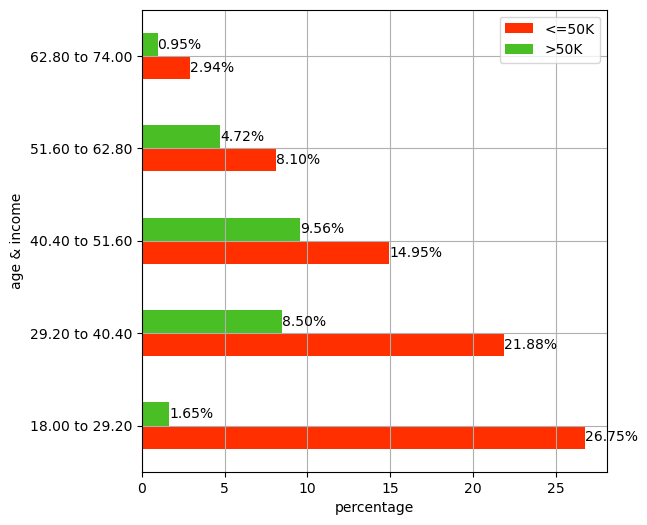

In [15]:

n_bins = 5
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy = 'uniform')
df_train['age_disc'] = est.fit_transform(df_train[['age']])
df_target['age_disc'] = est.transform(df_target[['age']])


df_grouped = df_train.groupby(['age_disc','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('age & income')
ax.set_xlabel('percentage')
plt.yticks(range(0,n_bins),
           [f'{est.bin_edges_[0][ptr]:.2f} to {est.bin_edges_[0][ptr+1]:.2f}' for ptr in range(0,n_bins)])
ax.legend(loc='best')
ax.grid()
plt.savefig('./datasets/figures/age_disc.png',dpi=600)

#### Sexo (_sex_)
- Se muestra que 2/3 de los encuestados son hombres, y los hombres que superan el target de ingresos representan el 21% del total.
- La discrepancia porcentual es mayor entre los que llegan o no al target es mayor en mujeres que en hombres
- Para ambos sexos, la mayoría no llega al target de ingresos anuales
- Se implementa un simple label encoder (con mapping para reutilizar el código)

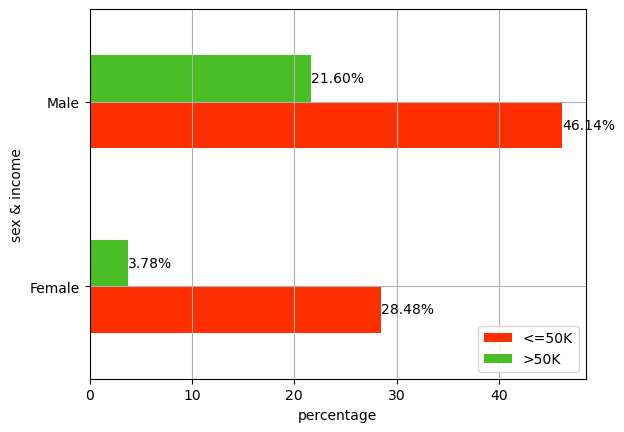

In [16]:
df_grouped = df_train.groupby(['sex','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen])
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('sex & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

# 0: Male, 1: Female
mapping_dict = {
    'Male':0,
    'Female':1
}

plt.savefig('./datasets/figures/sex.png',dpi=600)

df_train['sex_encoded'] = df_train['sex'].replace(mapping_dict)
df_target['sex_encoded'] = df_target['sex'].replace(mapping_dict)

#### Etnicidad (_race_):
- Una gran parte de los encuestados son blancos (~86\%), es la etnia que más disparidad porcentual tiene en cuanto al porcentaje de personas que superan el target de ingresos anuales (casi un 40\% de discrepancia)
- La segunda etnia más encuestrada son los afro-decendientes, con un 9.32\%, entre ellos hay menor discrepancia porcentual entre los que superan o no el target de ingresos (un poco menos de 7\%).
- Las discrepancias se pueden explicar debido a la disparidad muestreal respecto a la cantidad de encuestrados de la etnia caucásica respecto a las demás
- Se realiza una codificación con un diccionario con dos categorías (blancos y otros), para aumentar la cantidad de muestras en la variable codificada. El hecho de tener que hacer este tipo de codificación es un argumento para evaluar no utilizar esta variable para el modelo más adelante.

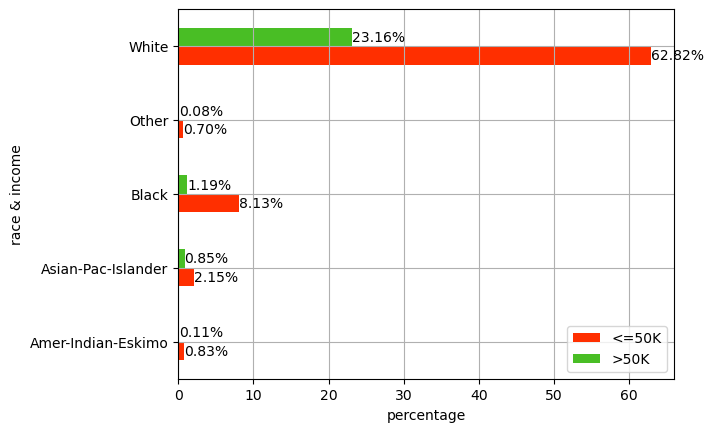

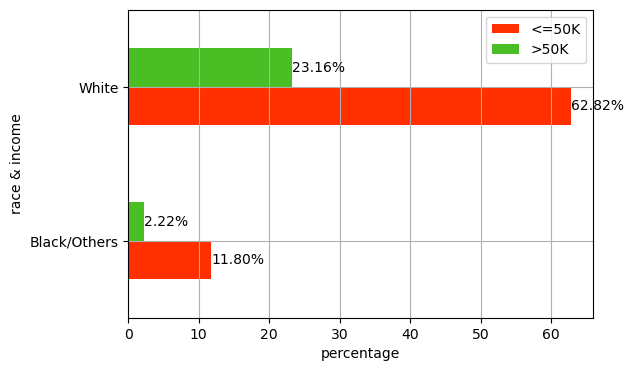

In [17]:
df_grouped = df_train.groupby(['race','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen])
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('race & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

plt.savefig('./datasets/figures/race.png',dpi=600)

# 0: Others, 1: White
mapping_dict = {
    'White':1,
    'Black':0,
    'Other':0,
    'Asian-Pac-Islander':0,
    'Amer-Indian-Eskimo':0,
}

df_train['race_encoded'] = df_train['race'].replace(mapping_dict)
df_target['race_encoded'] = df_target['race'].replace(mapping_dict)

df_grouped = df_train.groupby(['race_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1],['Black/Others','White'])
ax.set_ylabel('race & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/race_enc.png',dpi=600)


#### Nivel de educación (_education_):
- Se muestra claramente que se comienza a ver un porcentaje relevante de personas que superan el target de ingreso a partir de los Highschool graduates (gente que se graduó de la escuela secundaria), aunque la disparidad porcentual entre los que llegan al target de ingresos es la más marcada en este grupo
- A medida que las personas adquieren mayor nivel de educación, la disparidad porcentual va cambiando de signo, y comienzan a ser más las personas que tienen un ingreso superior al target a partir del nivel de educación "Masters" (finalizados 5 años de carrera universitaria)
- Se realiza una codificación con 3 niveles de educación (Bajo, Medio y Alto), para asegurar una representatividad de cada categoría. El hecho de tener que hacer este tipo de codificación es un argumento para evaluar no utilizar esta variable para el modelo más adelante.

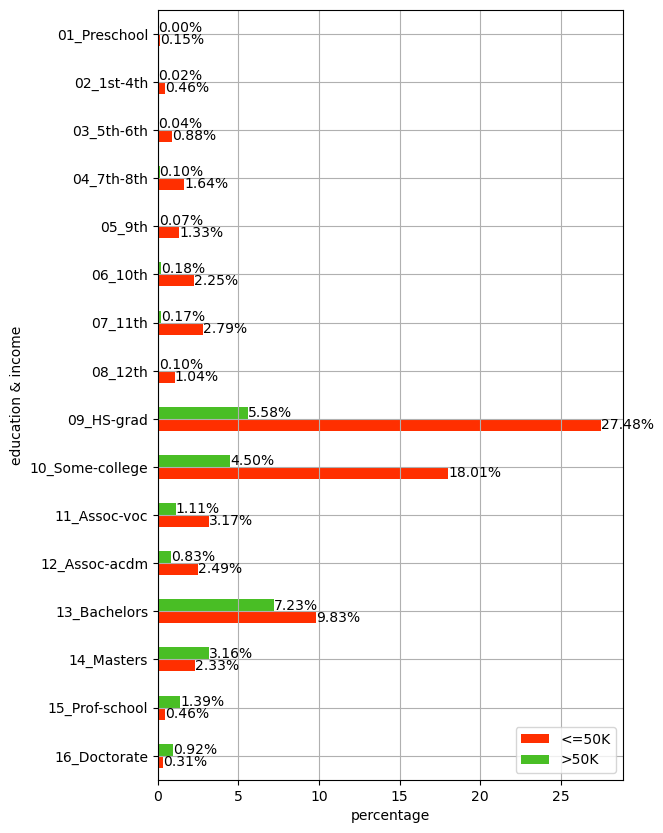

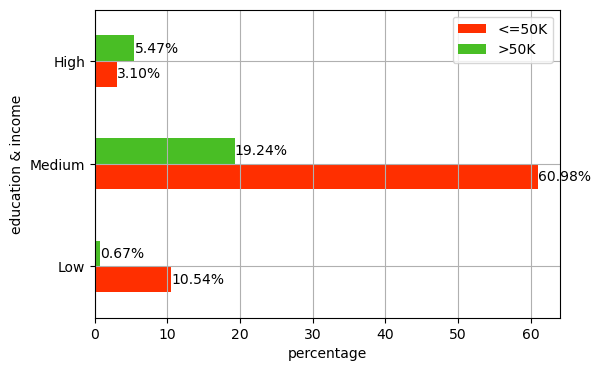

In [18]:
df_grouped = df_train.groupby(['education_numbered','income']).count()['ID']*100/len(df_train)
df_grouped = df_grouped.unstack().sort_values(['education_numbered'],ascending=False)
ax = df_grouped.plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,10))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('education & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

plt.savefig('./datasets/figures/education.png',dpi=600)

# 0: Low, 1: Medium, 2: High
mapping_dict = {
    '01_Preschool':0,
    '02_1st-4th':0,
    '03_5th-6th':0,
    '04_7th-8th':0,
    '05_9th':0,
    '06_10th':0,
    '07_11th':0,
    '08_12th':0,
    '09_HS-grad':1,
    '10_Some-college':1,
    '11_Assoc-voc':1,
    '12_Assoc-acdm':1,
    '13_Bachelors':1,
    '14_Masters':2,
    '15_Prof-school':2,
    '16_Doctorate':2
}

df_train['education_encoded'] = df_train['education_numbered'].replace(mapping_dict)
df_target['education_encoded'] = df_target['education_numbered'].replace(mapping_dict)

df_grouped = df_train.groupby(['education_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1,2],['Low','Medium','High'])
ax.set_ylabel('education & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/education_enc.png',dpi=600)


#### Ocupación (_ocupation_): 
- En ninguna ocupación hay una mayor cantidad de gente que gane más del target anual.
- La ocupación más pareja entre los que ganan menos del target anual y los que ganan más es en posiciones ejecutivas o management, seguida de profesionales o especiastas.
- La ocupación menos pareja entre los que ganan menos y más del target anual es en la ocupación de 'servicios', seguida de los administrativos
- Se realiza una codificación con un mapeo separando trabajos de oficina (White Collar) de oficios, trabajos manuales y trabajos que no se realizan en oficina (Blue Collar). El hecho de tener que hacer este tipo de codificación es un argumento para evaluar no utilizar esta variable para el modelo más adelante.

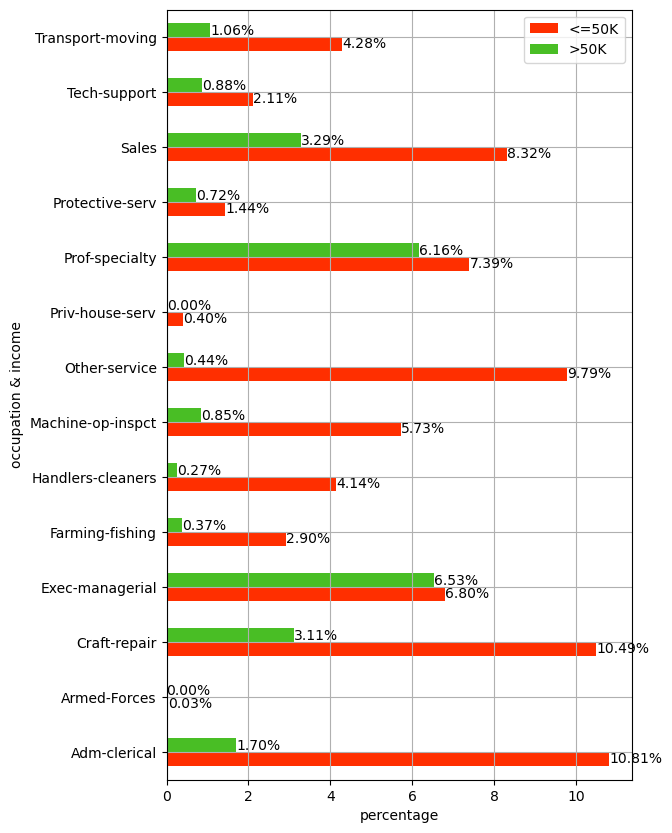

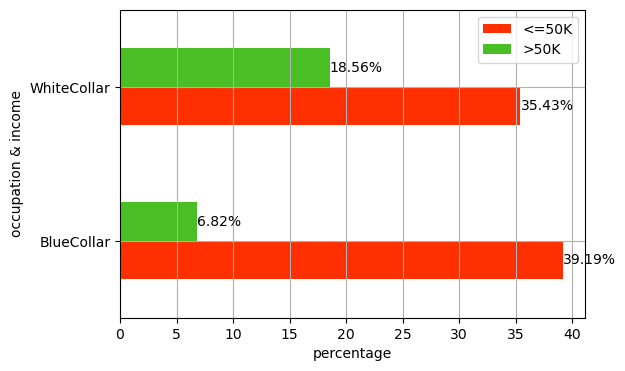

In [19]:
df_grouped = df_train.groupby(['occupation','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,10))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('occupation & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/occupation.png',dpi=600)

# 0 BLueCollar, 1: WhiteCollar
mapping_dict = {
    'Protective-serv':0,
    'Exec-managerial':1, 
    'Craft-repair':0,
    'Prof-specialty':1, 
    'Tech-support':1,
    'Other-service':0,
    'Transport-moving':0,
    'Adm-clerical':1,
    'Farming-fishing':0,
    'Handlers-cleaners':0,
    'Sales':1,
    'Machine-op-inspct':0,
    'Priv-house-serv':0,
    'Armed-Forces':0
}
df_train['occupation_encoded'] = df_train['occupation'].replace(mapping_dict)
df_target['occupation_encoded'] = df_target['occupation'].replace(mapping_dict)

df_grouped = df_train.groupby(['occupation_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1],['BlueCollar','WhiteCollar'])
ax.set_ylabel('occupation & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/occupation_enc.png',dpi=600)

#### Clase de trabajador (_workclass_):
- Se puede ver que un porcentaje muy alto (mayor al 70\%) de los encuestados trabajan en el sector privado, lo que puede generar conclusiones sesgadas.
- Los trabajadores del sector privado son los que tienen mayor porcentaje de personas por encima del target de ingreso, pero los de mayor disparidad porcentual respecto a los que están por debajo.
- El único sector que tiene mayor porcentaje con ingresos mayores al target es 'self-emp-inc', los que tienen la misma personalidad legal que la empresa donde trabajan.
- Se realiza una codificación con un mapeo separando trabajos del sector público y el privado, y generando una nueva categorías para Self-Employed y personas que no reciben un ingreso. El hecho de tener que hacer este tipo de codificación es un argumento para evaluar no utilizar esta variable para el modelo más adelante.

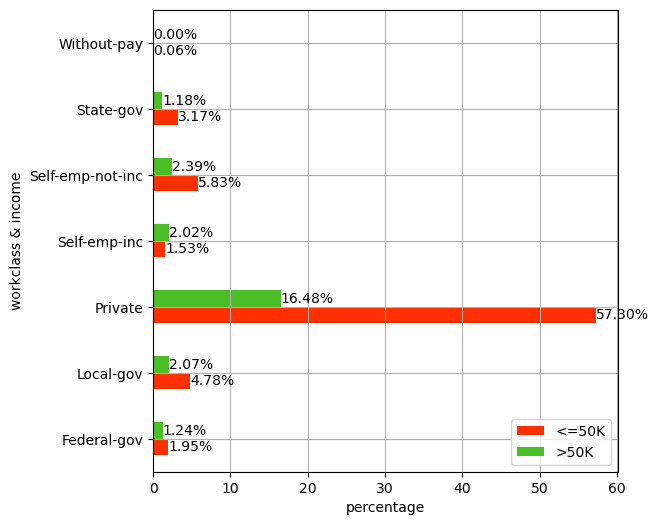

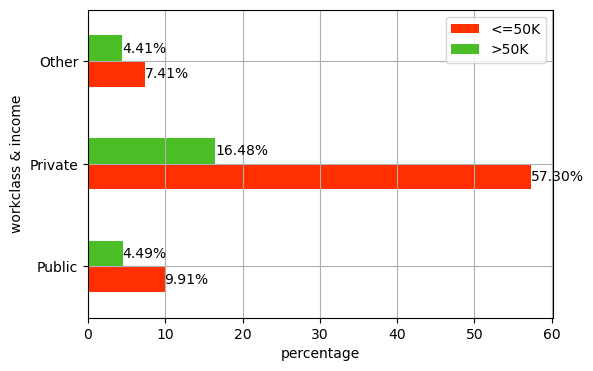

In [20]:
df_grouped = df_train.groupby(['workclass','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('workclass & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

plt.savefig('./datasets/figures/workclass.png',dpi=600)

# 0 Public, 1 Private, 2 Other
mapping_dict = {
    'Federal-gov':0,
    'Local-gov':0,
    'Private':1,
    'Self-emp-inc':2,
    'Self-emp-not-inc':2,
    'State-gov':0,
    'Without-pay':2
}

df_train['workclass_encoded'] = df_train['workclass'].replace(mapping_dict)
df_target['workclass_encoded'] = df_target['workclass'].replace(mapping_dict)

df_grouped = df_train.groupby(['workclass_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1,2],['Public','Private','Other'])
ax.set_ylabel('workclass & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/workclass_enc.png',dpi=600)

#### Estado Civil (_maritial.status_)
- Se puede ver que las personas casadas con civiles conforman la mayoría de los encuestados y son los que porcentualmente más ocupan el sector por encima del target de ingresos.
- La gente que nunca se ha casado conforma la segunda cantidad de personas en la encuesta, pero a diferencia de los anteriores, casi la totalidad está exclusivamente por debajo del target.
- Para facilitar el análisis y agrupar categorías con muy pocos encuestados se realiza un mapeo en tres categorías: *Single* (solo los que nunca se casaron), *Married* (con civiles, con personal militar o con ausentes y *Alone* (gente que estuvo casada y no lo está más por cualquier motivo). Con esta categorización se puede ver claramente que la gente casada es la que más supera el target, y la que menor discrepancia porcentual tiene con los que no lo hacen.
- El hecho de tener que hacer este tipo de codificación es un argumento para evaluar no utilizar esta variable para el modelo más adelante.

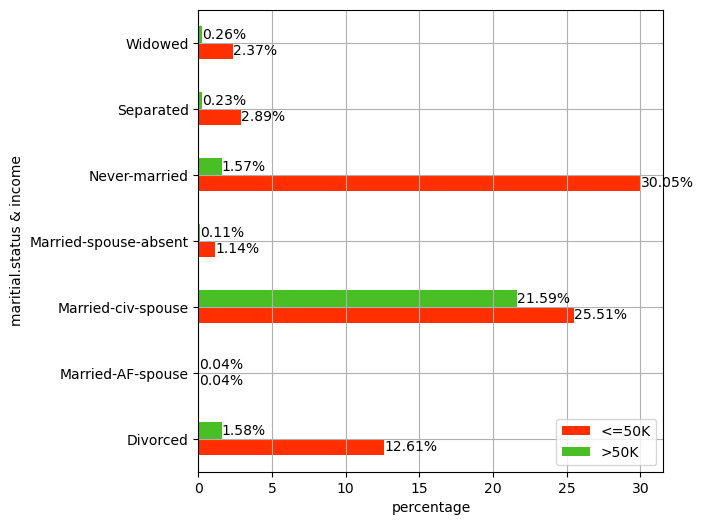

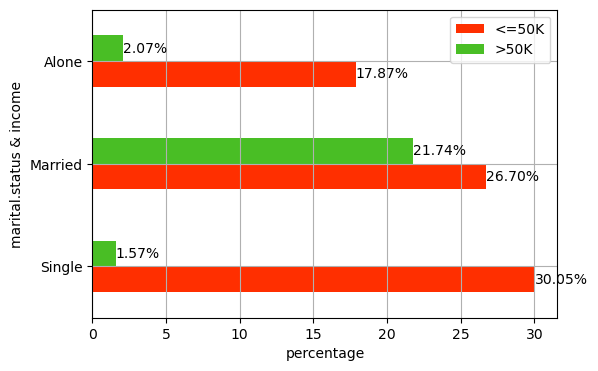

In [21]:
df_grouped = df_train.groupby(['marital.status','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('maritial.status & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

# 0 Single, 1 Married, 2 Alone
# Married AF (spouse in armed forces), Married civ (spouse civilian)
mapping_dict = {
    'Divorced':2,
    'Married-AF-spouse':1,
    'Married-civ-spouse':1,
    'Married-spouse-absent':1,
    'Never-married':0,
    'Separated':2,
    'Widowed':2
}

plt.savefig('./datasets/figures/maritial.png',dpi=600)

df_train['marital.status_encoded'] = df_train['marital.status'].replace(mapping_dict)
df_target['marital.status_encoded'] = df_target['marital.status'].replace(mapping_dict)

df_grouped = df_train.groupby(['marital.status_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1,2],['Single','Married','Alone'])
ax.set_ylabel('marital.status & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/maritial_enc.png',dpi=600)

#### Relación de pareja (_relationship_)
- Para hacer el análisis de esta variable más sencillo y asegurarse de que cada categoría tenga suficientes datos, se mapea la variable en dos categorías: Con familia directa (esposa/hijos) y sin familia directa (sin esposa, hijos o viviendo con otros familiares)
- Se puede ver que la mayoría de los encuestados no tiene familia (~60%) y que una gran porporción de las personas con familia tiene ingresos mayores al target. Con respecto a la gente con familia directa, la diferencia porcentual entre quienes no llegan al target de ingresos es más marcada.

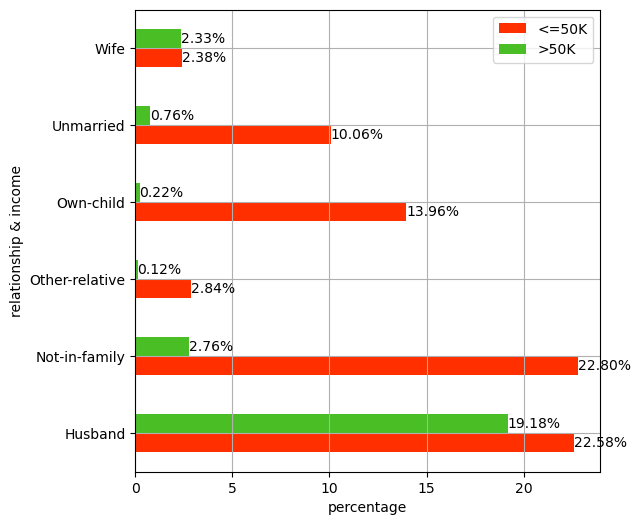

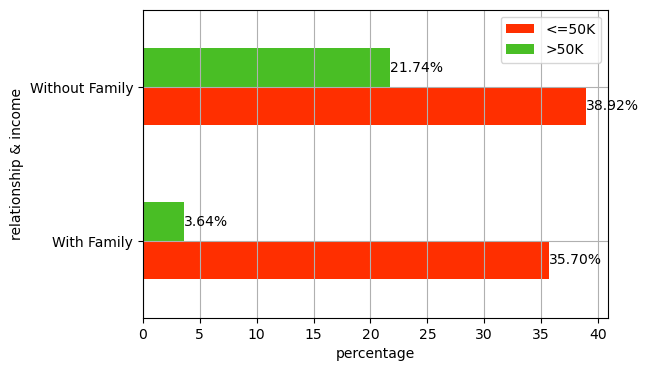

In [22]:
df_grouped = df_train.groupby(['relationship','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('relationship & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

# 1 With Direct Family, 0 Without Family or Direct Family
mapping_dict = {
    'Husband':1,
    'Not-in-family':0,
    'Other-relative':0,
    'Own-child':1,
    'Unmarried':0,
    'Wife':1
}

plt.savefig('./datasets/figures/relationship.png',dpi=600)

df_train['relationship_encoded'] = df_train['relationship'].replace(mapping_dict)
df_target['relationship_encoded'] = df_target['relationship'].replace(mapping_dict)

df_grouped = df_train.groupby(['relationship_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1],['With Family','Without Family'])
ax.set_ylabel('relationship & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/relationship_enc.png',dpi=600)

#### País de origen (_native.country_)
- Al plotear todos los países se encuentra que más del 90% de los encuestados es de EE.UU
- Se genera un mapeo para distinguir a los ciudadanos estadounidenses de otras naciones combinadas y se muestra la distribución de quién supera el target de ingresos. La discrepancia porcentual en los estadounidenses es mucho más marcada que la de ciudadanos de otras nacionalidades combinadas.

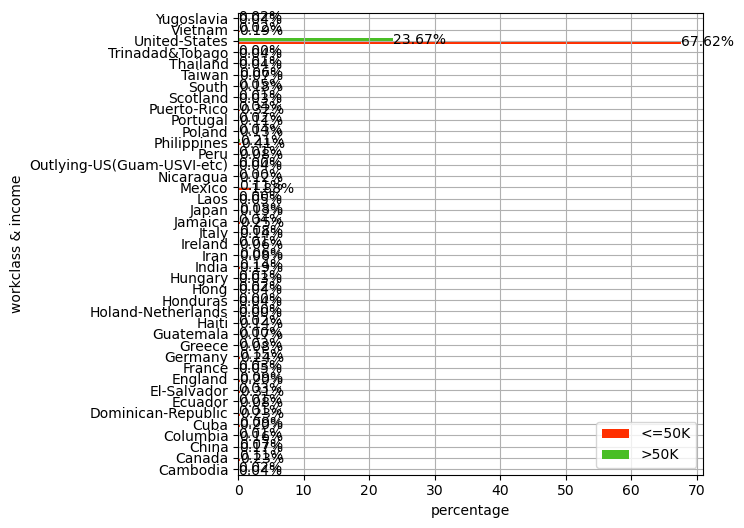

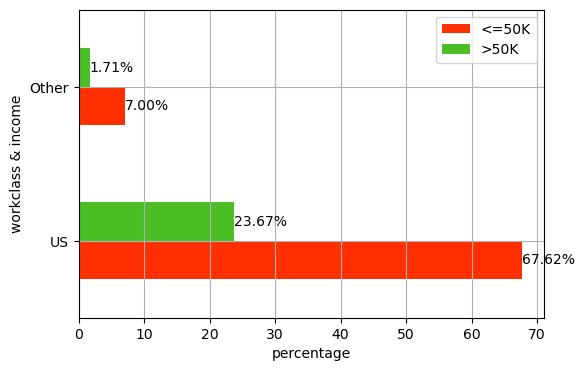

In [23]:
df_grouped = df_train.groupby(['native.country','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('workclass & income')
ax.set_xlabel('percentage')
ax.legend(loc='lower right')
ax.grid()

plt.savefig('./datasets/figures/countries.png',dpi=600)

df_train['native.country_encoded'] = [0 if country=='United-States' else 1 for country in df_train['native.country'] ]
df_target['native.country_encoded'] = [0 if country=='United-States' else 1 for country in df_target['native.country'] ]

df_grouped = df_train.groupby(['native.country_encoded','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,4))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_yticks([0,1],['US','Other'])
ax.set_ylabel('workclass & income')
ax.set_xlabel('percentage')
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/countries_enc.png',dpi=600)

#### Horas trabajadas semanalmente (_hours.per.week_):
- Se utilizó un kbins discretizer para separarlos en 5 bins uniformes, ya que era una variable continua con mucha dispersión
- Se puede ver que la mayoría más del 70\% trabaja entre 25.5 y 50 horas semanales, y este grupo es el que más porcentaje de personas también tiene mas gente por encima del target ingreso, pero con la disparidad más marcada en cuanto a cuánta gente esta por encima o debajo del este target.
- A priori no pareciera existir una correlación entre trabajar muchas horas y llegar al target de ingreso, ya que el porcentaje de gente que supera el target trabajando pocas horas es similar al porcentaje que lo supera trabajando muchas.

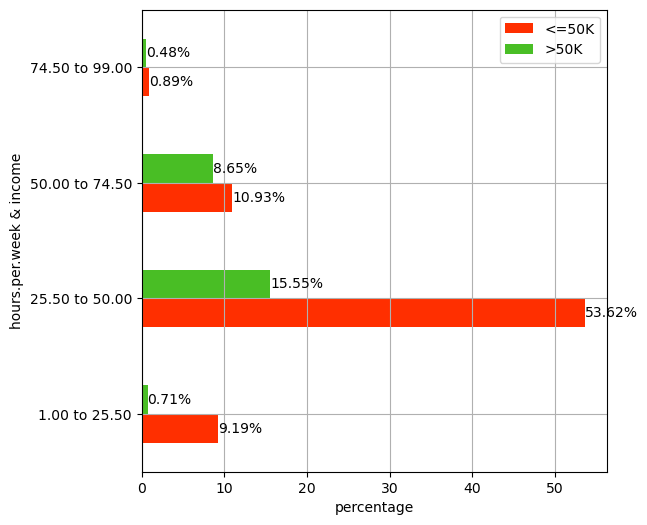

In [24]:
# La variable hours.per.week es una variable continua, se puede utilizar un Kbins encoder

n_bins = 4
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy = 'uniform')
df_train['hours.per.week_disc'] = est.fit_transform(df_train[['hours.per.week']])
df_target['hours.per.week_disc'] = est.transform(df_target[['hours.per.week']])


df_grouped = df_train.groupby(['hours.per.week_disc','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('hours.per.week & income')
ax.set_xlabel('percentage')
plt.yticks(range(0,n_bins),
           [f'{est.bin_edges_[0][ptr]:.2f} to {est.bin_edges_[0][ptr+1]:.2f}' for ptr in range(0,n_bins)])
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/hours_disc.png',dpi=600)

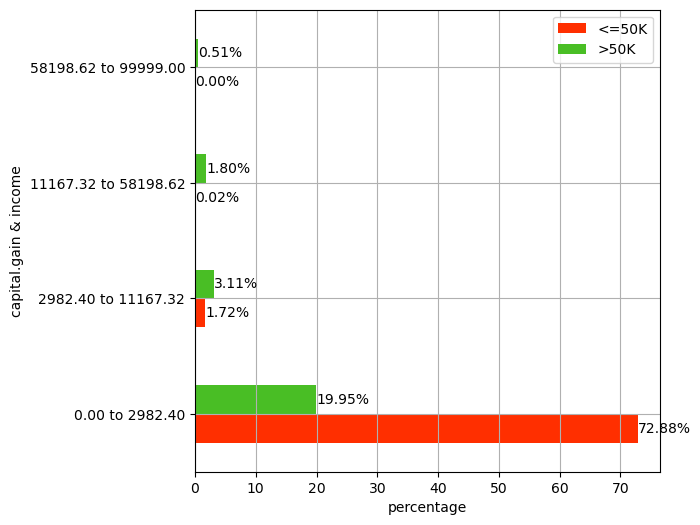

In [25]:
n_bins = 4
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy = 'kmeans')
df_train['capital.gain_disc'] = est.fit_transform(df_train[['capital.gain']])
df_target['capital.gain_disc'] = est.transform(df_target[['capital.gain']])

df_grouped = df_train.groupby(['capital.gain_disc','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('capital.gain & income')
ax.set_xlabel('percentage')
plt.yticks(range(0,n_bins),
           [f'{est.bin_edges_[0][ptr]:.2f} to {est.bin_edges_[0][ptr+1]:.2f}' for ptr in range(0,n_bins)])
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/capital_gain_disc.png',dpi=600)

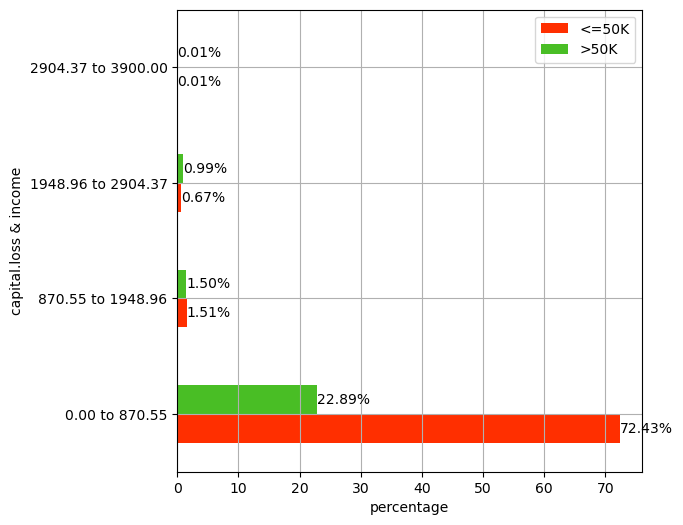

In [26]:

n_bins = 4
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy = 'kmeans')
df_train['capital.loss_disc'] = est.fit_transform(df_train[['capital.loss']])
df_target['capital.loss_disc'] = est.transform(df_target[['capital.loss']])

df_grouped = df_train.groupby(['capital.loss_disc','income']).count()['ID']*100/len(df_train)
ax = df_grouped.unstack().plot(kind='barh', stacked=False,color=[myRed,myGreen],figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}%')
ax.set_ylabel('capital.loss & income')
ax.set_xlabel('percentage')
plt.yticks(range(0,n_bins),
           [f'{est.bin_edges_[0][ptr]:.2f} to {est.bin_edges_[0][ptr+1]:.2f}' for ptr in range(0,n_bins)])
ax.legend(loc='best')
ax.grid()

plt.savefig('./datasets/figures/capital_loss_disc.png',dpi=600)

#### Generación de la variable income binaria

In [27]:
# 1 More than 50k, 0 less than 50k
mapping_dict = {
    '<=50K': 0,
    '>50K': 1
}

df_train['more_50k'] = df_train['income'].replace(mapping_dict)

## Modelo de clasificación

Debido a los múltiples tipos de variables categóricas que presenta el análisis y que el objetivo del análisis es decidir si una persona va a tener tener un ingreso mayor a USD 50.000 anuales o no, se selecciona el árbol de decisión binario como modelo de clasificación. 

Se evaluaron las métricas del modelo para diferentes grupos de variables explicativas. Debido a que el dataset de test no presenta la variable a estimar, las métricas se evalúan únicamente sobre el dataset de entrenamiento y luego se generarán las predicciones sobre el dataset de test.

### Train-test split
- Luego del EDA se hace una prueba para determinar el tamaño óptimo para el train-test split con un árbol de decisión, se calcula el accuracy score para el train y el test
- En la figura se puede ver que para varias depths del árbol, no hay una clara divergencia para ninguna depth de los accuracy score de train y test para tamaños de test bajos. Hay mayor discrepancia entre los accuracy score para tamaños de test mayores al 60%.
- Se escoje un porcentaje conservador: 30% de los datos de train.csv se usaran para generar los datos de test el train-test split con un  para generar datos de test generar un modelo de clasificación y calificarlo con los datos de test.

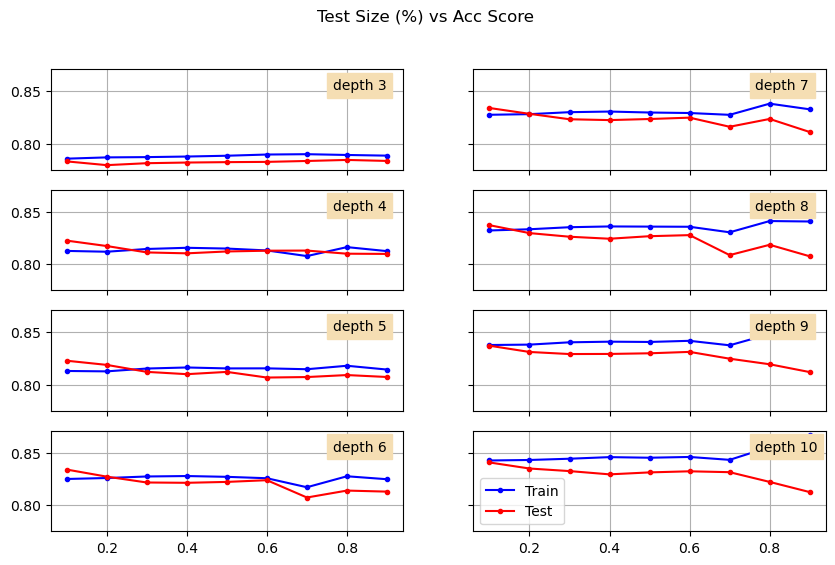

In [28]:
X = df_train.drop(columns=['income','more_50k'], axis=1)
y = df_train['more_50k']

cols_to_model = ['age_disc','sex_encoded','race_encoded', 'education_encoded',
                 'occupation_encoded', 'workclass_encoded', 'marital.status_encoded',
                 'relationship_encoded', 'native.country_encoded', 'hours.per.week_disc',
                 'capital.gain_disc', 'capital.loss_disc']

X = X[cols_to_model]

test_sizes = np.arange(0.1,1.0,0.1)
depths = np.arange(3,11)


fig, axes = plt.subplots(4,2,figsize=(10,6),sharex=True,sharey=True)
row_ptr = 0 
col_ptr = 0
    
for depth in depths:    
    train_acc_scores = []
    test_acc_scores = []
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                             test_size=test_size, 
                                                             train_size=1-test_size, 
                                                             random_state=1, 
                                                             shuffle=True, 
                                                             stratify=y)

        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X_train, y_train)
        train_preds = tree.predict(X_train)
        test_preds = tree.predict(X_test)
        train_acc_scores.append(accuracy_score(y_train, train_preds))
        test_acc_scores.append(accuracy_score(y_test, test_preds))    
    
    
    ax = axes[row_ptr][col_ptr]
    ax.plot(test_sizes,train_acc_scores,'b.-',label='Train')
    ax.plot(test_sizes,test_acc_scores,'r.-',label='Test')
    ax.grid(True)
    ax.annotate(text=f'depth {depth}',xy=(0.8,0.8),xycoords='axes fraction',backgroundcolor='wheat')
    if(row_ptr == 3 and col_ptr==1):
        ax.legend()
    
    row_ptr += 1
    if(row_ptr==4):
        row_ptr = 0
        col_ptr += 1
    
fig.suptitle('Test Size (%) vs Acc Score')
plt.savefig('./datasets/figures/train-test.png',dpi=600)

In [29]:
X = df_train.drop(columns=['income','more_50k'], axis=1)
y = df_train['more_50k']

X_train_all, X_test_all, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.3, 
                                                     train_size=0.7, 
                                                     random_state=1, 
                                                     shuffle=True, 
                                                     stratify=y)


#### Árbol de decisión con variables personales

- Se incluyen únicamente variables personales como potenciales variables explicativas de que una persona pueda o no tener un ingreso superior a USD 50k anuales. Las variables personales incluyen características intrínsecas de cada individuo (e.g: su edad, nacionalidad, etnicidad o estado civil), que idealmente no influir la capacidad de generación de ingresos de una persona
- Se entrena el árbol de decisión con diferentes depths. Para depths muy pequeñas el modelo no es funcional, como se verá en el análisis de las métricas
- El accuracy score (para train) sigue una tendencia logarítmica, tendiendo a 0.77 para profundidadas del árbol grandes, el mismo score para test es levemente más bajo pero sigue la misma tendencia
- El precision score (sensibilidad del modelo) es nulo depth pequeñas, es decir, el modelo no es capaz de generar True Positives. Para depths superiores o iguales a 5 alcanza su cota máxima en un valor muy pequeño, alrededor de 0.5. Este hecho indica que la cantidad de False Positives es similar a la de True Positives
- El recall score de train es nulo para depths pequeñas, consecuencia de que el modelo no puede generar True Positives. Para depths superiores o iguales a 5 también se estabiliza alrededor de 0.5. Este valor indica que la cantidad de False Negatives es similar a la de True Positives. El recall score de test se mantiene estable en 0.75 para cualquier depth, indicando que el modelo genera la misma cantidad de True positives para cualquier depth.
- La especificidad del modelo es relativamente alta para cualquier depth, es decir, el modelo es capaz de clasificar correctamente a las personas que no superan el target de ingresos, a costa de tener mayor cantidad de False negatives.
- El F1-score para depths bajas es nulo y para depths mayores tiende a un valor de 0.5, indicando que el modelo es relativamente malo para realizar predicciones. El F1-score se mantiene con la misma tendencia y valores muy similares tanto para el dataset de train como el de test, para todas las depths del árbol.
- La métrica de AUC (Area Under Curve) de ROC (Receiver Operating Characteristic) tiende a ser menor a 0.6 para depths superiores a 4, lo que puede considerarse como un desempeño bajo.
- Por último, se muestran el True Positive Rate y el False Positive Rate. Se puede ver que el modelo tiene un true positive rate y un false positive rate de 1 para depths bajas (lo que quiere decir que no está generando negativos, no hay ni True Negatives ni False Negatives, modela como si todos ganasen más de USD 50k). Para depths mayores el TPR y el FPR decrecen, pero el TPR lo hace a 0.5, indicando que el modelo no es muy bueno.

#### Conclusión

- Este modelo tiene una performance insuficiente, lo que es esperable ya que se han incluido variables que no deberían ser explicativas del ingreso de las personas. Si se quisiera utilizar este modelo la depth no debería ser menor a 10.
- Notar que el accuracy score es siempre mejor o igual que el caso baseline (suponer que nadie tiene un ingreso superior a USD 50k)

In [30]:
cols_to_model = ['age_disc','sex_encoded','race_encoded', 'marital.status_encoded',
                 'relationship_encoded', 'native.country_encoded']

X_train = X_train_all[cols_to_model]
X_test = X_test_all[cols_to_model]



c:\Users\fdadam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fdadam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fdadam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fdadam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

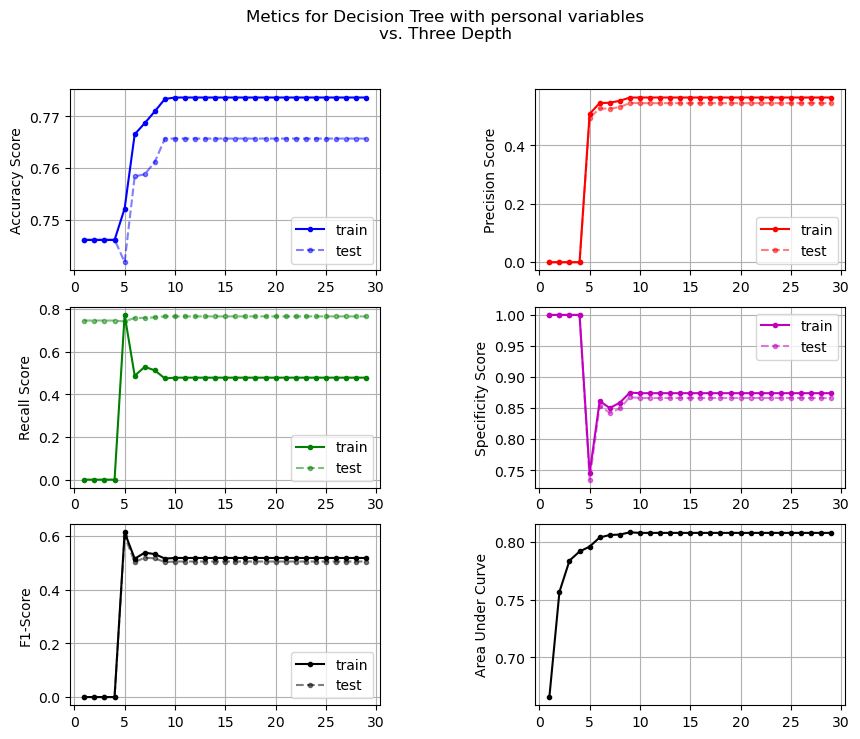

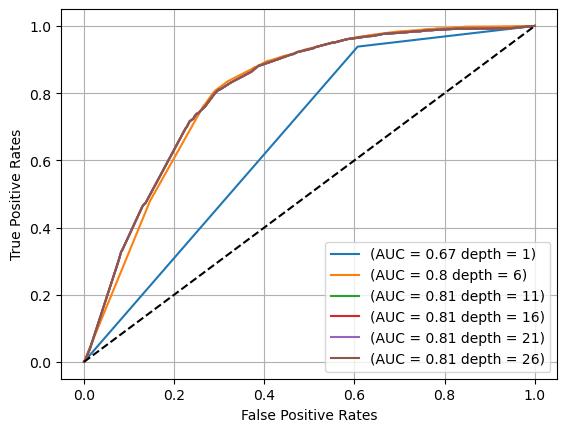

In [32]:
depth_list = np.arange(1,30)

acc_list_train = []
prec_list_train = []
recall_list_train = []
specificity_list_train = []
f1_list_train = []

acc_list_test = []
prec_list_test = []
recall_list_test = []
specificity_list_test = []
f1_list_test = []

fpr_list = []
tpr_list = []
auc_list = []

for depth in depth_list:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    train_preds = tree.predict(X_train)
    test_preds = tree.predict(X_test)
    
    acc_list_train.append(accuracy_score(y_train, train_preds))
    acc_list_test.append(accuracy_score(y_test, test_preds))
    
    prec_list_train.append(precision_score(y_train,train_preds))
    prec_list_test.append(precision_score(y_test,test_preds))
    
    recall_list_train.append(recall_score(y_train, train_preds))
    recall_list_test.append(recall_score(y_test, test_preds))
    
    specificity_list_train.append(recall_score(y_train, train_preds,pos_label=0))
    specificity_list_test.append(recall_score(y_test, test_preds,pos_label=0))
    
    f1_list_train.append(f1_score(y_train, train_preds))
    f1_list_test.append(f1_score(y_test, test_preds))
    
    y_pred_proba = tree.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    auc_list.append(auc(fpr, tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
fig, axes = plt.subplots(3,2,figsize=(10,8))
plt.subplots_adjust(wspace=0.5)
fig.suptitle('Metics for Decision Tree with personal variables\nvs. Three Depth')
ax = axes[0][0]
ax.plot(depth_list,acc_list_train,'b.-',label='train')
ax.plot(depth_list,acc_list_test,'b--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Accuracy Score')
ax.grid(True)

ax = axes[0][1]
ax.plot(depth_list,prec_list_train,'r.-',label='train')
ax.plot(depth_list,prec_list_test,'r--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Precision Score')
ax.grid(True)

ax = axes[1][0]
ax.plot(depth_list,recall_list_train,'g.-',label='train')
ax.plot(depth_list,acc_list_test,'g--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Recall Score')
ax.grid(True)

ax = axes[1][1]
ax.plot(depth_list,specificity_list_train,'m.-',label='train')
ax.plot(depth_list,specificity_list_test,'m--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Specificity Score')
ax.grid(True)

ax = axes[2][0]
ax.plot(depth_list,f1_list_train,'k.-',label='train')
ax.plot(depth_list,f1_list_test,'k--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('F1-Score')
ax.grid(True)

ax = axes[2][1]
ax.plot(depth_list,auc_list,'k.-')
ax.set_ylabel('Area Under Curve')
ax.grid(True)

plt.savefig('./datasets/figures/tree_pers.png')

fig, ax = plt.subplots(1,1)
for ptr in range(0,len(depth_list),5):
    ax.plot(fpr_list[ptr],tpr_list[ptr],label=f"(AUC = {round(auc_list[ptr],2)} depth = {depth_list[ptr]})")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.legend()
ax.set_xlabel('False Positive Rates')
ax.set_ylabel('True Positive Rates')
ax.grid()

plt.savefig('./datasets/figures/ROC_tree_pers.png',dpi=600)


#### Árbol de decisión con variables profesionales

- Se incluyen únicamente variables profesionales como potenciales variables explicativas de que una persona pueda o no tener un ingreso superior a USD 50k anuales. Las variables profesionales incluyen características intrínsecas de la carrera/profesión de cada individuo (e.g: su ocupación, clase trabajadora, la cantidad de horas por semana que trabaja, etc), que idealmente deberían ser las únicas que influencien la capacidad de generación de ingresos de una persona.
- Se entrena el árbol de decisión con diferentes depths. Para depths muy pequeñasm, si bien el modelo es funcional, las métricas indican que es un mal modelo.
- El accuracy score sigue una tendencia logarítmica, tendiendo a 0.82 para profundidadas del árbol grandes
- El precision score (sensibilidad del modelo) es relativamente bajo, incluso cuando se aumenta la depth del árbol, alcanzando una cota máxima alrededor de 0.73, un valor relativamente bajo.
- El recall score es muy bajo para el dataset de train, pero bastante alto para el de test, indicando que la generación de true positives es alta solo en el dataset de test. Para depths superiores a 3, se estabiliza alrededor de 0.4 para el dataset de train y 0.8 para el dataset de test.
- La especificidad del modelo es relativamente alta para cualquier depth, es decir, el modelo es capaz de clasificar correctamente a las personas que no superan el target de ingresos, a costa de tener mayor cantidad de False negatives. La especificidad tiene un comportamiento similar tanto para train como para test.
- El F1-score para el dataset de train es relativamente bajo para todas las depths, estabilizándose en un valor de 0.5, indicando que el modelo es relativamente malo para realizar predicciones. El F1-score para el dataset de test sigue la misma tendencia, estabilizándose en 0.45, lo que refureza la hipotesis anterior.
- La métrica de AUC (Area Under Curve) de ROC (Receiver Operating Characteristic) tiende a ser menor a 0.8 para depths superiores a 7, lo que puede considerarse como un desempeño aceptable, pero teniendo debe tenerse en cuenta lo mencionado sobre el F1-score.

#### Conclusión

- Este modelo tiene una performance insuficiente, lo que es interesante ya que se esperaría que las variables incluidas deberían influenciar fuertemente la capacidad de ingreso de las personas. Sin embargo, no se ha logrado modelizar eficientemente las circunstancias que generan un alto ingreso. 
- Notar que el accuracy score es siempre mejor o igual que el caso baseline (suponer que nadie tiene un ingreso superior a USD 50k)

In [33]:
cols_to_model = ['education_encoded','occupation_encoded', 'workclass_encoded','hours.per.week_disc',
                 'capital.gain_disc', 'capital.loss_disc']

X_train = X_train_all[cols_to_model]
X_test = X_test_all[cols_to_model]

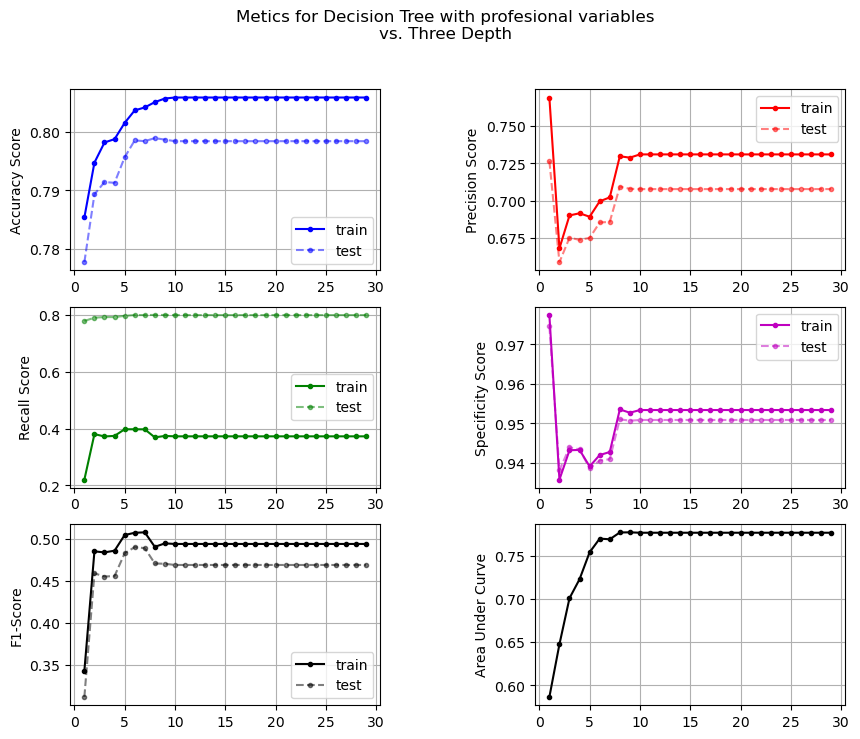

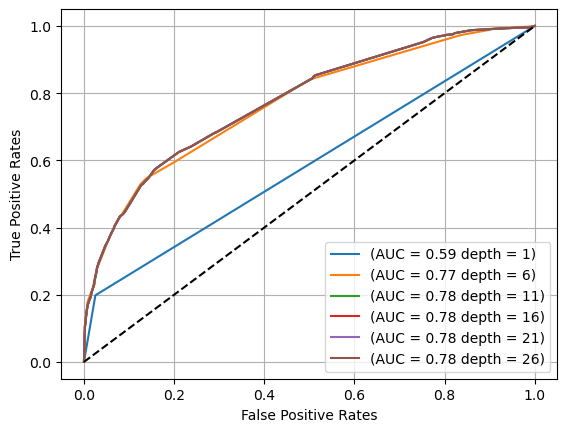

In [34]:
depth_list = np.arange(1,30)

acc_list_train = []
prec_list_train = []
recall_list_train = []
specificity_list_train = []
f1_list_train = []

acc_list_test = []
prec_list_test = []
recall_list_test = []
specificity_list_test = []
f1_list_test = []

fpr_list = []
tpr_list = []
auc_list = []

for depth in depth_list:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    train_preds = tree.predict(X_train)
    test_preds = tree.predict(X_test)
    
    acc_list_train.append(accuracy_score(y_train, train_preds))
    acc_list_test.append(accuracy_score(y_test, test_preds))
    
    prec_list_train.append(precision_score(y_train,train_preds))
    prec_list_test.append(precision_score(y_test,test_preds))
    
    recall_list_train.append(recall_score(y_train, train_preds))
    recall_list_test.append(recall_score(y_test, test_preds))
    
    specificity_list_train.append(recall_score(y_train, train_preds,pos_label=0))
    specificity_list_test.append(recall_score(y_test, test_preds,pos_label=0))
    
    f1_list_train.append(f1_score(y_train, train_preds))
    f1_list_test.append(f1_score(y_test, test_preds))
    
    y_pred_proba = tree.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    auc_list.append(auc(fpr, tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
fig, axes = plt.subplots(3,2,figsize=(10,8))
plt.subplots_adjust(wspace=0.5)
fig.suptitle('Metics for Decision Tree with profesional variables\nvs. Three Depth')
ax = axes[0][0]
ax.plot(depth_list,acc_list_train,'b.-',label='train')
ax.plot(depth_list,acc_list_test,'b--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Accuracy Score')
ax.grid(True)

ax = axes[0][1]
ax.plot(depth_list,prec_list_train,'r.-',label='train')
ax.plot(depth_list,prec_list_test,'r--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Precision Score')
ax.grid(True)

ax = axes[1][0]
ax.plot(depth_list,recall_list_train,'g.-',label='train')
ax.plot(depth_list,acc_list_test,'g--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Recall Score')
ax.grid(True)

ax = axes[1][1]
ax.plot(depth_list,specificity_list_train,'m.-',label='train')
ax.plot(depth_list,specificity_list_test,'m--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Specificity Score')
ax.grid(True)

ax = axes[2][0]
ax.plot(depth_list,f1_list_train,'k.-',label='train')
ax.plot(depth_list,f1_list_test,'k--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('F1-Score')
ax.grid(True)

ax = axes[2][1]
ax.plot(depth_list,auc_list,'k.-')
ax.set_ylabel('Area Under Curve')
ax.grid(True)

plt.savefig('./datasets/figures/tree_prof.png',dpi=600)

fig, ax = plt.subplots(1,1)
for ptr in range(0,len(depth_list),5):
    ax.plot(fpr_list[ptr],tpr_list[ptr],label=f"(AUC = {round(auc_list[ptr],2)} depth = {depth_list[ptr]})")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.legend()
ax.set_xlabel('False Positive Rates')
ax.set_ylabel('True Positive Rates')
ax.grid()

plt.savefig('./datasets/figures/ROC_tree_prof.png',dpi=600)

#### Árbol de decisión con todas las variables

- Se incluyen todas las variables como potenciales variables explicativas de que una persona pueda o no tener un ingreso superior a USD 50k anuales
- Se entrena el árbol de decisión con diferentes depths y se encuentra un punto de inflexión interesante a partir de una depth de 8.
- El accuracy score para train sigue una tendencia logarítmica, tendiendo a 0.86 para depths grandes. El accuracy para test sigue una tendencia similar hasta una depth de 8, donde empieza a diverger y se estabiliza el 0.825. Si bien no hay mucha diferencia relativa en estos valores, es interesante notar la divergencia del comportamiento de este score.
- El precision score (sensibilidad del modelo) tiende a valores pequeños para depth pequeñas, es decir, el modelo está teniendo mayor cantidad de False Positives (está indicando que alguien tiene un ingreso superior al target cuando no es así). Para mayores depths, esta métrica se estabiliza alrededor de 0.8 para train y 0.7 para test, divergiendo nuevamente alrededor de una depth de 8.
- El recall score es muy bajo para depths pequeñas, indicando que se está teniendo una mayor cantidad de False Negatives. Para mayores depths, esta métrica se estabiliza alrededor de 0.6 para train, pero permanece constante para test en 0.8 para cualquier depth.
- La especificidad del modelo es relativamente alta para cualquier depth, es decir, el modelo es capaz de clasificar correctamente a las personas que no superan el target de ingresos, a costa de tener mayor cantidad de False negatives. Nuevamente se ve una divergencia en una depth de 10 entre train y test.
- El F1-score para depths bajas es muy pequeño, indicando que el modelo no realiza predicciones correctas, sin embargo para depths superiores a 6, el F1-score tiende a un valor de 0.7, indicando que el modelo es relativamente bueno. Se debe notar que para test el F1-score diverge del F1-score de train para una depth superior a 8, lo que indicaría el punto óptimo para la depth del árbol.
- La métrica de AUC (Area Under Curve) de ROC (Receiver Operating Characteristic) tiende a ser mayor que 0.8 para depths superiores a 6, lo que puede considerarse como un desempeño muy bueno.

#### Conclusión

- Este modelo tiene la mejor performance entre 3 árboles generados, es decir, incluir todas las variables ha mejorado la posibilidad de predecir si alguien tendrá un ingreso mayor o menos a USD 50k. La depth del árbol de decisión a utilizar debe ser no menor a 6, y no mayor a 8 para conseguir las mejores métricas
- Notar que el accuracy score es siempre mejor o igual que el caso baseline (suponer que nadie tiene un ingreso superior a USD 50k)

In [35]:
cols_to_model = ['age_disc','sex_encoded','race_encoded', 'education_encoded',
                 'occupation_encoded', 'workclass_encoded', 'marital.status_encoded',
                 'relationship_encoded', 'native.country_encoded', 'hours.per.week_disc',
                 'capital.gain_disc', 'capital.loss_disc']

X_train = X_train_all[cols_to_model]
X_test = X_test_all[cols_to_model]

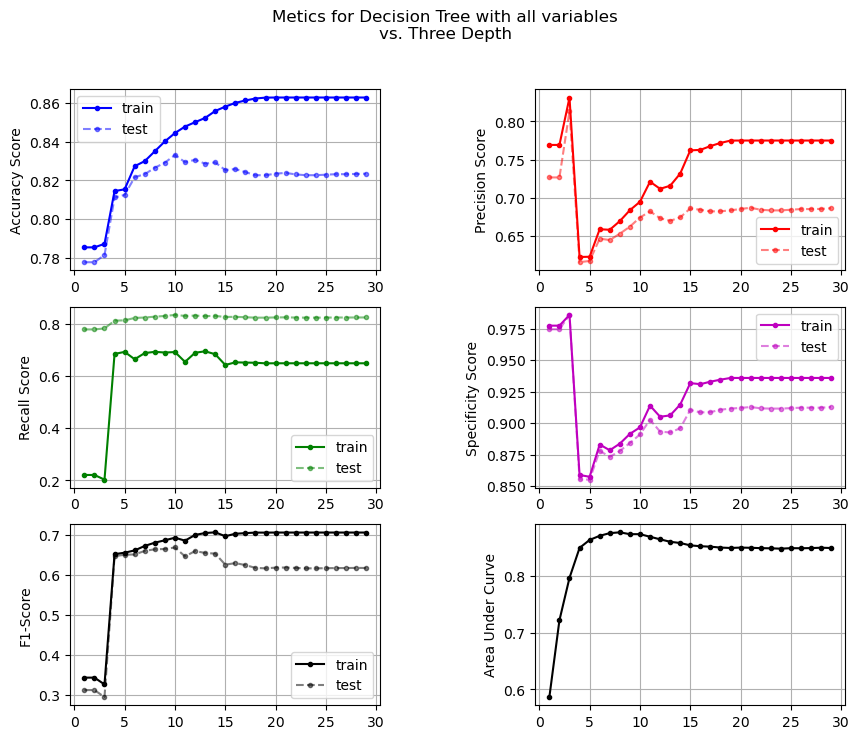

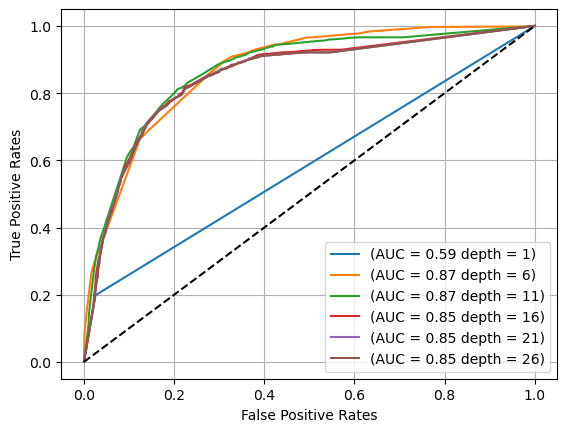

In [36]:
depth_list = np.arange(1,30)

acc_list_train = []
prec_list_train = []
recall_list_train = []
specificity_list_train = []
f1_list_train = []

acc_list_test = []
prec_list_test = []
recall_list_test = []
specificity_list_test = []
f1_list_test = []

fpr_list = []
tpr_list = []
auc_list = []

for depth in depth_list:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    train_preds = tree.predict(X_train)
    test_preds = tree.predict(X_test)
    
    acc_list_train.append(accuracy_score(y_train, train_preds))
    acc_list_test.append(accuracy_score(y_test, test_preds))
    
    prec_list_train.append(precision_score(y_train,train_preds))
    prec_list_test.append(precision_score(y_test,test_preds))
    
    recall_list_train.append(recall_score(y_train, train_preds))
    recall_list_test.append(recall_score(y_test, test_preds))
    
    specificity_list_train.append(recall_score(y_train, train_preds,pos_label=0))
    specificity_list_test.append(recall_score(y_test, test_preds,pos_label=0))
    
    f1_list_train.append(f1_score(y_train, train_preds))
    f1_list_test.append(f1_score(y_test, test_preds))
    
    y_pred_proba = tree.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc_list.append(auc(fpr, tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
fig, axes = plt.subplots(3,2,figsize=(10,8))
plt.subplots_adjust(wspace=0.5)
fig.suptitle('Metics for Decision Tree with all variables\nvs. Three Depth')
ax = axes[0][0]
ax.plot(depth_list,acc_list_train,'b.-',label='train')
ax.plot(depth_list,acc_list_test,'b--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Accuracy Score')
ax.grid(True)

ax = axes[0][1]
ax.plot(depth_list,prec_list_train,'r.-',label='train')
ax.plot(depth_list,prec_list_test,'r--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Precision Score')
ax.grid(True)

ax = axes[1][0]
ax.plot(depth_list,recall_list_train,'g.-',label='train')
ax.plot(depth_list,acc_list_test,'g--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Recall Score')
ax.grid(True)

ax = axes[1][1]
ax.plot(depth_list,specificity_list_train,'m.-',label='train')
ax.plot(depth_list,specificity_list_test,'m--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Specificity Score')
ax.grid(True)

ax = axes[2][0]
ax.plot(depth_list,f1_list_train,'k.-',label='train')
ax.plot(depth_list,f1_list_test,'k--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('F1-Score')
ax.grid(True)

ax = axes[2][1]
ax.plot(depth_list,auc_list,'k.-')
ax.set_ylabel('Area Under Curve')
ax.grid(True)

plt.savefig('./datasets/figures/tree_all.png',dpi=600)

fig, ax = plt.subplots(1,1)
for ptr in range(0,len(depth_list),5):
    ax.plot(fpr_list[ptr],tpr_list[ptr],label=f"(AUC = {round(auc_list[ptr],2)} depth = {depth_list[ptr]})")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.legend()
ax.set_xlabel('False Positive Rates')
ax.set_ylabel('True Positive Rates')
ax.grid()

plt.savefig('./datasets/figures/ROC_tree_all.png',dpi=600)

#### Knn con todas las variables

- Basado en el estudio con los modelos de árboles de decisión, se optó por incluir todas las variables como potenciales variables explicativas de que una persona pueda o no tener un ingreso superior a USD 50k anuales
- No es necesario escalar las variables para este modelo ya que se han hecho todas variables categóricas, donde su valor numérico únicamente representa una categoría y todas rondas el dominio de [0,4]
- Se entrena el modelo de Knn con diferente cantidad de neighbors y se muestran las métricas obtenidas
- El accuracy score para train tiende a 0.84 para grandes cantidades de neighbors. El accuracy para test sigue una tendencia similar, pero consistentemente más baja, llegando a superar 0.82 para 5 neighbors o más; con baja cantidad de neighbors esta métrica entre train y test son más diferentes entre sí.
- El precision score (sensibilidad del modelo) para train tiende oscilar con un valor medio aproximado de 0.72 para cantidad de neighbors superiores a 5, para test sigue un comportamiento similar con un score levemente más bajo.
- El recall score para train oscila en un valor relativamente bajo (0.55) para cualquier cantidad de neighbors, indicando que se está teniendo una gran cantidad de False Negatives. Para el dataset de test el recall score se mantiene en 0.8.
- La especificidad del modelo es relativamente alta para cualquier cantidad de neighbors, tanto para train como para test, es decir, el modelo es capaz de clasificar correctamente a las personas que no superan el target de ingresos, a costa de tener mayor cantidad de False negatives.
- El F1-score oscila entre 0.62 para train y 0.6 para test, indicando que el modelo es relativamente aceptable. La diferencia relativa entre los F1-score de train y de test se mantiene relativamente constante para cualquier cantidad de neighbors.
- La métrica de AUC (Area Under Curve) de ROC (Receiver Operating Characteristic) tiende a ser mayor que 0.85 para una cantidad de neighbors superiores a 6, lo que puede considerarse como un desempeño muy bueno.

#### Conclusión

- Este modelo una performance aceptable, similar a la de el árbol de decisión considerando todas las variables del dataset. Si se pretende utilizar este modelo se debe utilizar una cantidad de neigbors no menores a 5.
- Notar que el accuracy score es siempre mejor o igual que el caso baseline (suponer que nadie tiene un ingreso superior a USD 50k)

In [37]:
cols_to_model = ['age_disc','sex_encoded','race_encoded', 'education_encoded',
                 'occupation_encoded', 'workclass_encoded', 'marital.status_encoded',
                 'relationship_encoded', 'native.country_encoded', 'hours.per.week_disc',
                 'capital.gain_disc', 'capital.loss_disc']

X_train = X_train_all[cols_to_model]
X_test = X_test_all[cols_to_model]

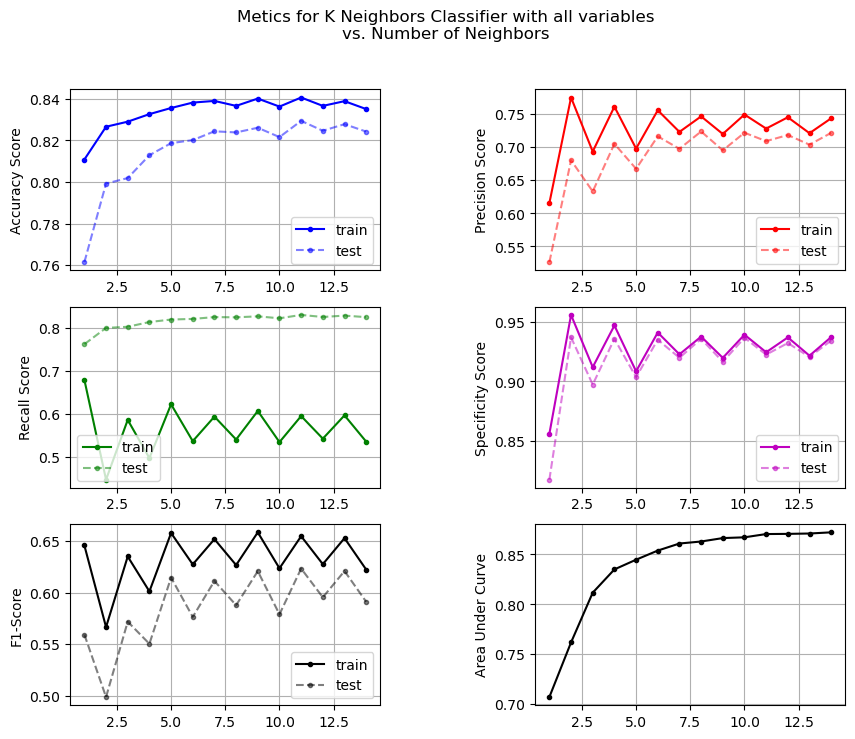

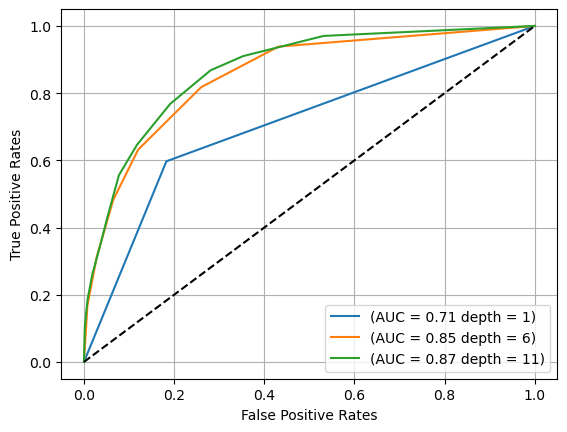

In [39]:
neighbors_list = np.arange(1,15)

acc_list_train = []
prec_list_train = []
recall_list_train = []
specificity_list_train = []
f1_list_train = []

acc_list_test = []
prec_list_test = []
recall_list_test = []
specificity_list_test = []
f1_list_test = []

fpr_list = []
tpr_list = []
auc_list = []

for neighbor in neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=neighbor,weights='uniform')
    knn.fit(X_train, y_train)
    train_preds = knn.predict(X_train)
    test_preds = knn.predict(X_test)
    
    acc_list_train.append(accuracy_score(y_train, train_preds))
    acc_list_test.append(accuracy_score(y_test, test_preds))
    
    prec_list_train.append(precision_score(y_train,train_preds))
    prec_list_test.append(precision_score(y_test,test_preds))
    
    recall_list_train.append(recall_score(y_train, train_preds))
    recall_list_test.append(recall_score(y_test, test_preds))
    
    specificity_list_train.append(recall_score(y_train, train_preds,pos_label=0))
    specificity_list_test.append(recall_score(y_test, test_preds,pos_label=0))
    
    f1_list_train.append(f1_score(y_train, train_preds))
    f1_list_test.append(f1_score(y_test, test_preds))
    
    y_pred_proba = knn.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    auc_list.append(auc(fpr, tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
fig, axes = plt.subplots(3,2,figsize=(10,8))
plt.subplots_adjust(wspace=0.5)
fig.suptitle('Metics for K Neighbors Classifier with all variables\nvs. Number of Neighbors')
ax = axes[0][0]
ax.plot(neighbors_list,acc_list_train,'b.-',label='train')
ax.plot(neighbors_list,acc_list_test,'b--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Accuracy Score')
ax.grid(True)

ax = axes[0][1]
ax.plot(neighbors_list,prec_list_train,'r.-',label='train')
ax.plot(neighbors_list,prec_list_test,'r--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Precision Score')
ax.grid(True)

ax = axes[1][0]
ax.plot(neighbors_list,recall_list_train,'g.-',label='train')
ax.plot(neighbors_list,acc_list_test,'g--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Recall Score')
ax.grid(True)

ax = axes[1][1]
ax.plot(neighbors_list,specificity_list_train,'m.-',label='train')
ax.plot(neighbors_list,specificity_list_test,'m--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('Specificity Score')
ax.grid(True)

ax = axes[2][0]
ax.plot(neighbors_list,f1_list_train,'k.-',label='train')
ax.plot(neighbors_list,f1_list_test,'k--',marker='.',alpha=0.5,label='test')
ax.legend()
ax.set_ylabel('F1-Score')
ax.grid(True)

ax = axes[2][1]
ax.plot(neighbors_list,auc_list,'k.-')
ax.set_ylabel('Area Under Curve')
ax.grid(True)

plt.savefig('./datasets/figures/knn_models.png')


fig, ax = plt.subplots(1,1)
for ptr in range(0,len(neighbors_list),5):
    ax.plot(fpr_list[ptr],tpr_list[ptr],label=f"(AUC = {round(auc_list[ptr],2)} depth = {neighbors_list[ptr]})")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.legend()
ax.set_xlabel('False Positive Rates')
ax.set_ylabel('True Positive Rates')
ax.grid()

plt.savefig('./datasets/figures/ROC_knn.png',dpi=600)

#### Modelo Seleccionado

Para finalizar el práctico, bajo todo lo expuesto, se ha seleccionado el árbol de decisión generado considerando todas las variables con una depth de 7.

In [40]:
cols_to_model = ['age_disc','sex_encoded','race_encoded', 'education_encoded',
                 'occupation_encoded', 'workclass_encoded', 'marital.status_encoded',
                 'relationship_encoded', 'native.country_encoded', 'hours.per.week_disc',
                 'capital.gain_disc', 'capital.loss_disc']

X_train = X_train_all[cols_to_model]
X_test = X_test_all[cols_to_model]

treeAllVariables = DecisionTreeClassifier(max_depth=7)
treeAllVariables.fit(X_train, y_train)
train_preds = treeAllVariables.predict(X_train)
test_preds = treeAllVariables.predict(X_test)

Classification Report - Train
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     13146
           1       0.66      0.69      0.67      4472

    accuracy                           0.83     17618
   macro avg       0.77      0.78      0.78     17618
weighted avg       0.83      0.83      0.83     17618



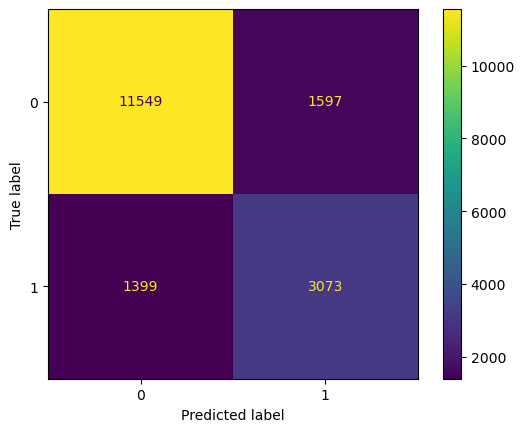

In [41]:
print('Classification Report - Train')
print(classification_report(y_train, train_preds))

cm = confusion_matrix(y_train, train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Classification Report - Test
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5635
           1       0.64      0.68      0.66      1916

    accuracy                           0.82      7551
   macro avg       0.77      0.77      0.77      7551
weighted avg       0.83      0.82      0.82      7551



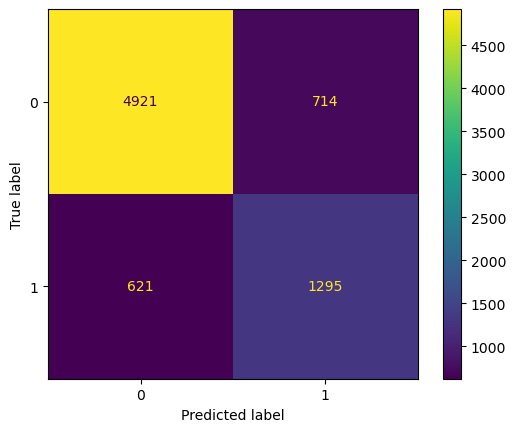

In [42]:
print('Classification Report - Test')
print(classification_report(y_test, test_preds))
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Generación de la solución

In [43]:
df_target_model = df_target[cols_to_model]

df_target['PRED'] = treeAllVariables.predict(df_target_model)

df_target_csv = df_target[['ID','PRED']]
df_target_csv.to_csv('./datasets/submit_dadam.csv',index=False)